In [1]:
import duckdb as db
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def sql(query, database = "../data/database.duckdb"):
    con = db.connect(database)
    res = con.execute(query).df()
    con.close()
    return res

In [4]:
df = pd.DataFrame(sql(
    """  
    SELECT 
    startYear,
    runtimeMinutes
    FROM title_basics
    ORDER BY startYear 
    """
))

In [5]:
df = df[df['runtimeMinutes'].str.isnumeric()]
df = df[df['startYear'].str.isnumeric()]
df['runtimeMinutes'] = df['runtimeMinutes'].astype(int)
df['decade'] = df['startYear'].map(lambda x : (int(x)//10)*10)
df.groupby('decade')['runtimeMinutes'].mean().reset_index()


,decade,runtimeMinutes
0,1890,85.250000
1,1900,68.333333
2,1910,61.647468
3,1920,71.597367
4,1930,80.321209
5,1940,85.817031
6,1950,90.329374
7,1960,92.841720
8,1970,90.479972
9,1980,91.736200


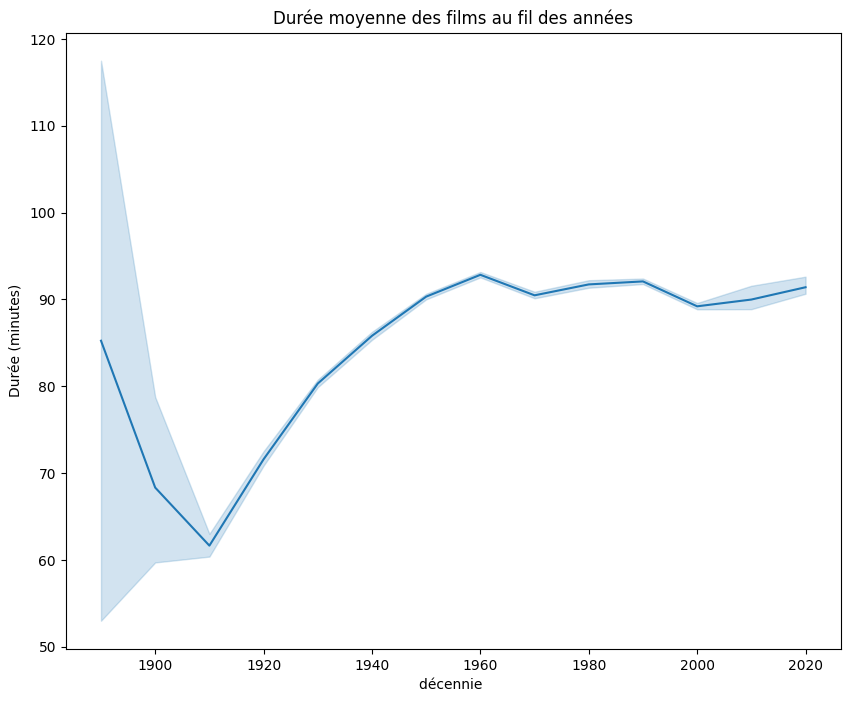

In [6]:
plt.figure(figsize=(10,8))
sns.lineplot(
    data=df,
    x= 'decade',
    y='runtimeMinutes'
)
plt.title('Durée moyenne des films au fil des années')
plt.ylabel('Durée (minutes)')
plt.xlabel('décennie ')
plt.savefig('../visuals/duree_moyenne_films.png')
plt.show()

In [13]:
sql(
    """  
    SELECT
    *
    FROM name_basics
    where birthYear not like '\\N'
    limit 10
    """
)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
5,nm0000006,Ingrid Bergman,1915,1982,"actress,producer,soundtrack","tt0034583,tt0038109,tt0036855,tt0038787"
6,nm0000007,Humphrey Bogart,1899,1957,"actor,producer,miscellaneous","tt0034583,tt0043265,tt0033870,tt0037382"
7,nm0000008,Marlon Brando,1924,2004,"actor,director,writer","tt0078788,tt0068646,tt0047296,tt0070849"
8,nm0000009,Richard Burton,1925,1984,"actor,producer,director","tt0061184,tt0087803,tt0059749,tt0057877"
9,nm0000010,James Cagney,1899,1986,"actor,director,producer","tt0029870,tt0031867,tt0042041,tt0034236"


In [3]:
df = pd.DataFrame(sql("""    
    
WITH writers_expanded AS (
    SELECT
        tc.tconst,
        nb.primaryName AS Writer
    FROM title_crew tc
    CROSS JOIN UNNEST(string_split(tc.writers, ',')) AS writer_nconst(nconst)
    JOIN name_basics nb ON nb.nconst = writer_nconst.nconst
)

SELECT
    tb.tconst AS tconst,
    string_agg(DISTINCT actors.primaryName, ', ') AS Actors,

FROM title_basics tb
JOIN title_akas ta ON tb.tconst = ta.titleId
JOIN title_crew tc ON tb.tconst = tc.tconst
CROSS JOIN UNNEST(string_split(tc.directors, ',')) AS director_nconst(nconst)
JOIN name_basics directors ON directors.nconst = director_nconst.nconst
JOIN title_principals tp ON tb.tconst = tp.tconst
JOIN name_basics actors ON tp.nconst = actors.nconst
JOIN tmdb t ON tb.tconst = t.imdb_id
JOIN title_ratings tr ON tb.tconst = tr.tconst
LEFT JOIN writers_expanded we ON tb.tconst = we.tconst
WHERE tp.category IN ('actor', 'actress')

GROUP BY tb.tconst

    """))

df

,tconst,Actors
0,tt0003330,"Olga Engl, William Wauer, Manny Ziener, Giusep..."
1,tt0003740,"Umberto Mozzato, Carolina Catena, Raffaele di ..."
2,tt0004182,"Robert Cummings, George Nash, Clarence Handysi..."
3,tt0006509,"William Hinckley, Jewel Carmen, W.E. Lawrence,..."
4,tt0006568,"Marcelle Hontabat, William E. Shay, Ricca Alle..."
...,...,...
172872,tt9095324,Chris Martin
172873,tt4985564,Tom Stechschulte
172874,tt6348244,Jeffrey Wright
172875,tt11941042,Lesley Steele


In [4]:
actors_series = df['Actors'].str.split(', ')
actors_list = [actor for sublist in actors_series for actor in sublist]
actors_list = list(filter(lambda x: x not in ["\\N", "Adult"], actors_list))
df_actors = pd.Series(actors_list)

In [5]:
df_actors = df_actors.value_counts().head(10)

In [6]:
df_actors  = pd.DataFrame(df_actors)
df_actors = df_actors.reset_index()

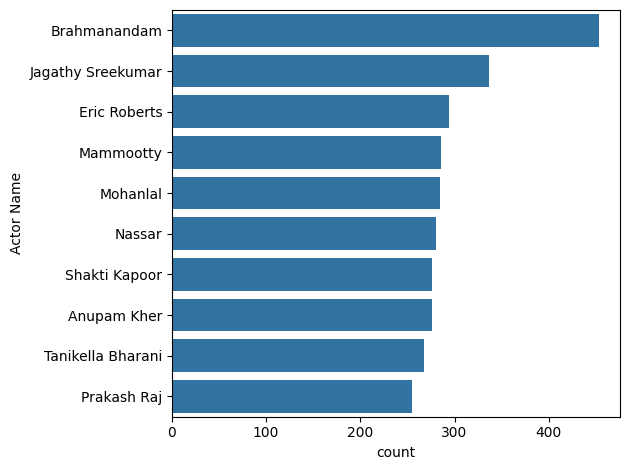

In [13]:
plt.Figure(figsize=(10,10))
sns.barplot(data=df_actors, y='index',x='count')
plt.ylabel('Actor Name')
plt.tight_layout()
plt.savefig('../visuals/top_acteurs.png')
plt.show()